In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Analyzing Light Curves
1. Creating Light Curves
    - Differential Photometry in a Nutshell
    - Reading in your data
1. Plotting Light Curves
    - Phased Plots
2. Spectral Analysis
    - Fourier Transforms
    - Interlude: The Sampling Theorem
    - However: Don't worry
3. Fitting Light Curves
    - Start with a guess

### Differential Photometry in a Nutshell

While traditional photometry requires "photometric" nights and observations of an extinction star, differential photometry literally divides it all out, along with the effects of moonlight and maybe even clouds! 

This is possible by comparing the magnitude of the target start to the magnitudes of *comparison stars* in the same image. This relative photometry removes changes that effect all stars in the image equally. 

$ \text{corrected target}(t) = \text{target}(t) - \frac{\text{comp1}(t) + \text{comp2}(t) + \text{comp3}(t) + \ldots}{\text{ncomps} } $

(Since we're working in magnitudes I actually subtracted the average of the comparison stars. If you were working in counts--which is *flux*--we would have done the obvious thing and divided.)

Comparison stars should:
- exist in *every image*
- be similar in brightness to each other (or use weighted average?)
- have stable magnitudes throughout the observation run.

We check the comparison stars by using a *Check Star*. Remove any comparison stars that don't change together.

### Differential Photometry Example

Variable RXJ1643.7+3402 with three comparison stars (A, B, and C) and a check star (D):

![](rx_chart.gif)

![](rx_comparison_stars.png)

In addition, plot your stars compared to a check-star (D) to ensure no funny business:


| Image | RX-D | A-D | B-D | C-D |
| ----- | ---- | --- | --- | --- |
|  1    | 0.99 | 0.94| 0.59| 1.1 |
|  2    | 1.05 | 0.90| 0.62| 1.05 |
|  etc... |

Some people also show these checks ('+') along with the target star's light curve (dots).
![](eclipse+comp.png)
TrES-1, from Birney D.S., Gonzalez G., Oesper D. Observational Astronomy. 2nd ed., Cambridge University Press, 2006.


### Reading in your light curve

Lots of ways to do this. I like numpy's `genfromtxt()` because it  creates a structure of numpy arrays and uses column headers to label the data. It also has many other options that can be just what one needs at times, see:

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

(Pandas' `readcsv()` is really neat too, but then there's an additional step to generate a numpy array.)

In [3]:
lc = np.genfromtxt('MACHO_10.3430.8.dat', names=True)
t = lc['date']
mag = lc['bmag']

### Plotting  your light curve

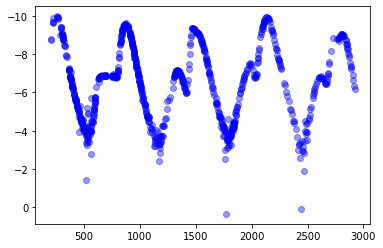

In [7]:
plt.plot(t,mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

### Plotting a folded (or phased) light curve
Use the modulo ('%') function to divide out the period, leaving only remainders.

Note: I've been using this method for years, there are newer ways: 
http://docs.astropy.org/en/stable/timeseries/

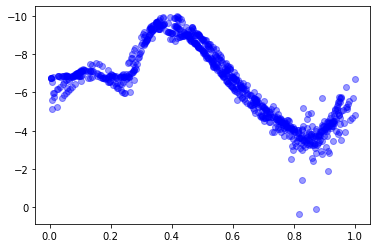

In [8]:
period = 629.8
plt.plot((t % period)/period, mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

### The Devious Double-Folded Light Curve
This style of light curve shows two periods, which shows the structure of the light curve without abitrary endpoints, but it's devious because every data point is plotted twice...

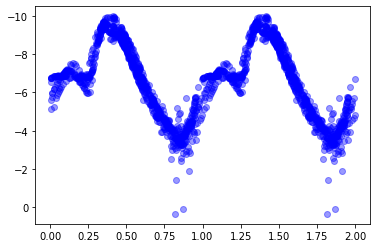

In [9]:
x = np.append( (t % period)/period, (t % period)/period + 1 )
y = np.append( mag, mag )
plt.plot( x, y, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

### Spectral Analysis of Light Curves
Real light curve data usually looks like this, but math will come to the rescue!

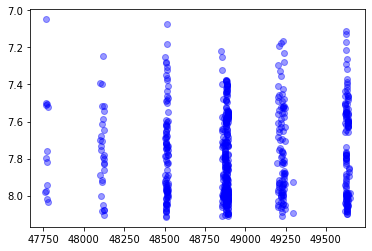

In [10]:
lc = np.genfromtxt('TU_Cas.dat', names=['date','mag'])
t = lc['date']
mag = lc['mag']

plt.plot(t,mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

### Fourier transforms
A real Fourier code will transform the data from temporal space to frequency space; it's completely equivalent to fitting sine curves at a bunch of different frequencies, and plotting a measure of much of each frequency to use.

The plot below is actually a periodigram, which for years was the only easily available fourier-based method. It's okay because we're just paying attention to the location of the highest peak, which we can then use to find a period.

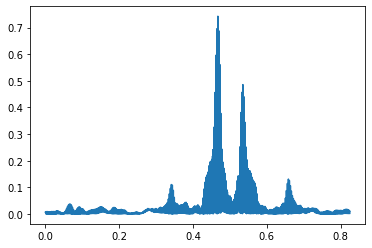

In [12]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(t, mag).autopower()
plt.plot(frequency, power)

A Lomb Scargle Periodigram is just a power spectrum scaled so the y-axis is a probability:

http://docs.astropy.org/en/stable/stats/lombscargle.html

FYI, I've been using this method for years, but there are newer ways: 

http://docs.astropy.org/en/stable/timeseries/

### Why we use Fourier Analysis

The highest amplitudes are where the data actually kinda looks like a sine curve at that frequency. Because a light curve can be periodic but not sine-like, in practise a Fourier transform may miss the best frequency, but is often used to generate a good initial guess for fitting.

period = 2.139280671887414


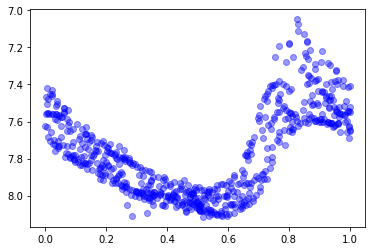

In [13]:
period = 1./frequency[np.argmax(power)] # note use of argmax()
print ("period =", period)
plt.plot((t % period)/period, mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

## Interlude: The Sampling Theorem

The Sampling Theorem, attributed to Claude Shannon (1949), is very useful for understanding and analyzing astronomical light curves. It defines the Nyquist Frequency (based on work by Harry Nyquist in 1928) as:

$$
f_{Nyquist} \equiv \frac{1}{2\delta}
$$

where $\delta$ is the time between observations. This limit is important because:

1. You cannot detect frequencies above the Nyquist Frequency. 
2. But the power in those frequencies will be present ("aliased") into the range you are searching.

## Sampling Theorem Demo


Lets see how this looks. If we observe once per day, 

$$
f_{Nyquist} = \frac{1}{2 \times 1} = 0.5
$$

for 100 days...

And then define a light curve with a higher frequency than the Nyquist frequency

$$ 
P_{Sine Wave} = 0.9 \qquad f_{Sine Wave} = 1.11 > f_{Nyquist}
$$

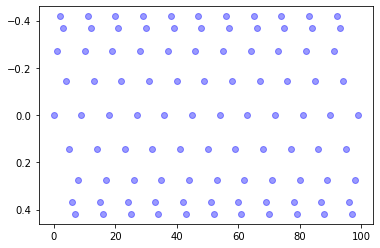

In [16]:
def Sine(t, amp = 1.0, offset = 0.0, period = 1.0, phase = 0.0):
    y = np.sin( 2*np.pi/period*(t-phase) )
    return amp/2 * y + offset

period=0.9
amp=0.85
offset = 0
phase=0.45

t = np.arange(0,100,1.)
mag = Sine(t, amp, offset, period, phase)

plt.plot(t,mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

Input period was 0.9 days (f = 1.1111111111111112 )
LombScargle period = 0.4739109621828626 (f = 2.11010101010101 )


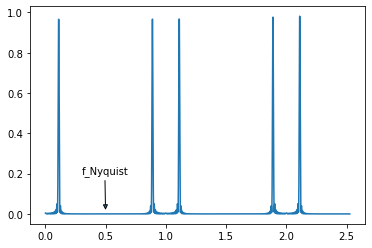

In [33]:
# http://docs.astropy.org/en/stable/stats/lombscargle.html
frequency, power =  (t, mag).autopower()
plt.plot(frequency, power)
max_f = frequency[np.argmax(power)]
plt.annotate("f_Nyquist", xy=(0.5,0.01), xytext=(0.3, 0.2),arrowprops=dict(arrowstyle='-|>'))
#annotate("f_real", xy=(1.11+0.05,0.01), xytext=(1.21, 0.2),arrowprops=dict(arrowstyle='-|>'))
#annotate("f_LombScargle", xy=(max_f+0.05,0.01), xytext=(max_f+0.1, 0.2),arrowprops=dict(arrowstyle='-|>'))

print( "Input period was", period, "days (f =", 1/period, ")" )
lsperiod = 1./frequency[np.argmax(power)]
print( "LombScargle period =", lsperiod, "(f =", frequency[np.argmax(power)], ")" )

### Nyquist Limits

This leads to the following limits:

$$
P_{max} = \mathrm{timespan}      \qquad f_{min} =  \frac{1}{\mathrm{timespan}} 
$$
$$
P_{min} = \frac{\mathrm{timespan}}{n_{obs}/2} \qquad f_{max} = f_{Nyquist} = \frac{n_{obs}/2}{\mathrm{timespan}}
$$

(Because astronomical data is rarely taken in such a perfectly regular fashion, I find it useful to define everything in terms of the average time between observations rather than $\delta$.)



## However: Don't Worry

Astronomical data is rarely taken in a perfectly regular fashion; this ensures unequal time sampling--which collapses the uncertainty for frequencies well above the Nyquist Frequency. So, jiggle your samples around just a little bit, and you can commonly search up to $f_{max} = 10*f_{Nyquist}$.

When using a Discrete Fourier Transform method you often have to specify the spacing of the frequencies you'll search. The exact same criteria apply to $f_{\delta}$ as they did to $f_{max}$: I typically set $f_{\delta} = f_{Nyquist}/10$. A great reference to all of this is the four pages of *Numerical Recipes in C*, second edition (1992): Section  13.8: Spectral Analysis of Unevenly Sampled Data.

* Weird results can become familier by generating the "window function". This is just what we did in this example: define a regular sine curve sampled with your data's time array, and feed that into the Fourier code. The result, which you know should have only one real peak, is the "window" through which simple sine curves are seen when sampled the same way as your data.

### Fitting Light Curves
In practise, fitting is more accurate than Fourier methods for non-sinusoidal light-curves, but since fits often require a guess, use a Fourier method to generate one!

### Example: A Challenging Light Curve:

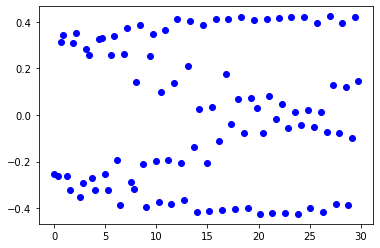

In [42]:
import scipy.optimize as optimize

def add_noise(x, amp=0.1):
    return np.asarray([i + (amp*(np.random.random()-0.5)) for i in x])

# this is actually where the light "curve" gets defined
# note parameters below, both for t (observations) and Sine curve
t = add_noise(np.arange(0,30,0.31))
mag = Sine(t, amp=0.85, period=1.25, phase=0.45)
 
plt.plot(t,mag, 'bo')
plt.gca().invert_yaxis()

### Generate a guess w/ Fourier

period = 1.2470591415356092


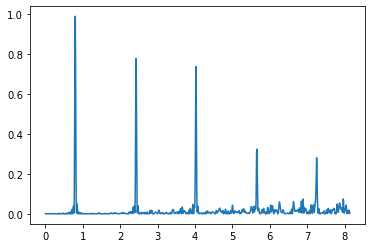

In [47]:
frequency, power = LombScargle(t, mag).autopower()
plt.plot(frequency, power)
#axis([0,0.01, 0, 0.9])
period = 1./frequency[np.argmax(power)]
print ("period =", period)

### Fit with a Sine Curve

amp = -0.850000000000077 offset = -2.286609500926982e-11 period = 1.250000000000041 phase = -0.17500000000037488


/Users/ojf/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


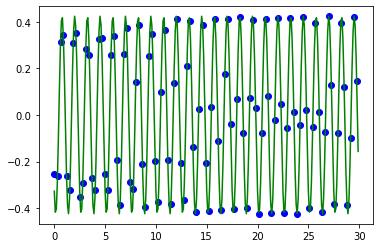

In [50]:
# it's important to give it a good guess, 
# so put in the period that Lomb-Scargle found.
guess = [1,0,period,0]
fit = optimize.curve_fit(Sine, t, mag, guess)
(amp, offset, period, phase) = fit[0]
print ("amp =", amp, "offset =", offset, "period =", period, "phase =", phase)

x = np.arange(0, 30, 0.1)
plt.plot(t,mag, 'bo')
plt.plot(x, Sine(x, amp, offset, period, phase), 'g-')
plt.gca().invert_yaxis()

#### It gets worse

![](bad_light_curve.png)

#### Actual "huh?" plot from a previous 481...

### Light Curve Recovered!

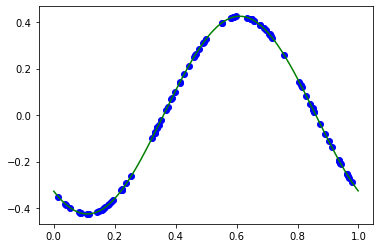

In [52]:
plt.plot((t % period)/period, mag, 'bo')
x = np.arange(0, period, period/1000) # one thousand points ought to look pretty smooth
plt.plot( x / period, Sine(x, amp, offset, period, phase), 'g-' )
plt.gca().invert_yaxis()